# Prepare

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.metrics import ConfusionMatrixDisplay
import os
import importlib
import sys
sys.path.append('./')
import NAB_scorer
importlib.reload(NAB_scorer)
from NAB_scorer import NABScorer

In [2]:
def plot_anomaly_scores(data, title, windows, threshold, labels):
    fig, ax1 = plt.subplots(figsize=(18, 6))
    # Ensure data.index is a pandas DatetimeIndex
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
        
    # Plot Oil Pressure and Pump Operation on the left y-axis
    ax1.plot(data.index, data['oil_pressure_u2'], label='Oil Pressure', color='b', alpha=0.8)
    ax1.plot(data.index, data['oil_pump_u2'].apply(lambda x: 100 if x == 1 else x), label='Pump Operation', color='g', linestyle='--', alpha=0.8)
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Value')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Plot Anomaly Score on the right y-axis
    ax2 = ax1.twinx()
    ax2.plot(data.index, data['anomaly_score'], label='Anomaly Score', color='r', linestyle='-.', alpha=0.8)
    ax2.axhline(y=threshold, color='purple', linestyle=':', label=f'Threshold ({threshold:.2f})')
    ax2.set_ylabel('Anomaly Score')
    ax2.legend(loc='upper right')

    # Highlight the anomaly windows
    for start, end in windows:
        ax1.axvspan(start, end, color='orange', alpha=0.3, label='Anomaly Window')
        
    # Avoid duplicate legend entries for windows
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys(), loc='upper left')

    plt.title(title)
    plt.show()

def plot_confusion_matrix(confusion_matrix, title="Confusion Matrix"):
    tp, tn, fp, fn = confusion_matrix['tp'], confusion_matrix['tn'], confusion_matrix['fp'], confusion_matrix['fn']
    cm = np.array([[tn, fp], [fn, tp]])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
    fig, ax = plt.subplots(figsize=(3, 3))
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(title)
    plt.show()

def plot_all(score):
    for file_name, file_score in score.items():
        base_name = '_'.join(file_name.split('_')[:2])
        plot_anomaly_scores(
            data_dict[file_name], 
            f'{base_name.replace('.csv', '')} with Anomaly Score',
            windows=file_score['windows'], 
            threshold=file_score['threshold'],
            labels=label_dict[base_name]
        )

        plot_confusion_matrix(
            file_score['confusion_matrix'], 
            title=f"Confusion Matrix for {base_name}"
        )

# Load all score files from the results directory
def load_score_files(results_dir):
    data_dict = {}
    for file_name in os.listdir(results_dir):
        if file_name.endswith('_scored.csv'):
            file_path = os.path.join(results_dir, file_name)
            short_file_name = '_'.join(file_name.split('_')[:2]) + '.csv'
            data_dict[short_file_name] = pd.read_csv(file_path, index_col='timestamp')
    return data_dict

In [12]:
label_dict = json.load(open('./data/labels_window.json'))
scores_total = []

## Score all models with all profiles

In [7]:
import NAB_scorer
import importlib

# Reload the module to ensure the latest changes are available
importlib.reload(NAB_scorer)
from NAB_scorer import NABScorer

# Define the models and profiles
model_names = ['lstm_TL_u2', 'lstm_TL_u1', 'lstm_small', 'lstm_TL_p2']
profiles = ['standard', 'reward_low_FP_rate', 'reward_low_FN_rate']

# Initialize the scorer and scores_total
scorer = NABScorer()
scores_total = []

# Loop through each model and profile
for model_name in model_names:
    results_dir = f'./results/{model_name}'
    data_dict = load_score_files(results_dir)  # Load data for the current model
    
    profile_scores = []
    for profile in profiles:
        # Compute the score for the current model and profile
        score = scorer.score(data_dict, label_dict, label_windowed=True, profile=profile)
        
        # Calculate average score across all files
        average_score = sum(file_score['score'] for file_score in score.values()) / len(score)
        
        # Create an entry for the current model-profile combination
        row = {
            'model': model_name,
            'profile': profile,
            # 'score': score,
            'average_score': average_score
        }
        
        # Add individual file scores to the row
        for file_name, file_score in score.items():
            row[file_name] = file_score['score']
        
        # Append the row to scores_total
        scores_total.append(row)

        profile_scores.append(average_score)
        # Print scores for individual files in the current evaluation
        for file_name, file_score in score.items():
            print(f"Model: {model_name}, Profile: {profile}, File: {file_name}, Score: {file_score['score']}")
        
        # Optionally plot all scores (can be commented if not needed)
        # plot_all(score)
    # append average scores for the current model with all profiles to the scores_total
    scores_total.append({
        'model': model_name,
        'profile': 'all',
        'average_score': sum(profile_scores) / len(profile_scores)
    })
    

# Output scores_total
df_scores = pd.DataFrame(scores_total)
display(df_scores)


windows: [(Timestamp('2024-04-01 01:04:00'), Timestamp('2024-04-01 01:29:00'))]
Normalized Score: 92.04, 
            score=0.8407850447119221, 
            threshold=0.6363636363636364, 
            TP=8, TN=55, FP=0, FN=18

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 01:52:00'))]
Normalized Score: 94.26, 
            score=0.8851426312614474, 
            threshold=0.8363636363636363, 
            TP=5, TN=134, FP=0, FN=22

windows: [(Timestamp('2024-04-01 01:48:00'), Timestamp('2024-04-01 05:05:00'))]
Normalized Score: 87.84, 
            score=0.756830594195369, 
            threshold=0.3181818181818182, 
            TP=126, TN=78, FP=0, FN=72

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 04:44:00'))]
Normalized Score: 84.26, 
            score=0.6852657009019265, 
            threshold=0.8181818181818181, 
            TP=25, TN=116, FP=0, FN=174

Model: lstm_TL_u2, Profile: standard, File: inter_leakage2.csv, Score: 92.03925223559611
Mo

model             profile  average_score  inter_leakage2.csv  \
0   lstm_TL_u2            standard      89.600300           92.039252   
1   lstm_TL_u2  reward_low_FP_rate      91.680240           93.631402   
2   lstm_TL_u2  reward_low_FN_rate      86.173790           90.270270   
3   lstm_TL_u2                 all      89.151443                 NaN   
4   lstm_TL_u1            standard      89.963522           93.039140   
5   lstm_TL_u1  reward_low_FP_rate      91.970818           94.431312   
6   lstm_TL_u1  reward_low_FN_rate      87.769071           89.090909   
7   lstm_TL_u1                 all      89.901137                 NaN   
8   lstm_small            standard      88.088548           90.841852   
9   lstm_small  reward_low_FP_rate      90.470838           92.673482   
10  lstm_small  reward_low_FN_rate      84.073926           88.354430   
11  lstm_small                 all      87.544437                 NaN   
12  lstm_TL_p2            standard      91.266139           96.212121   
13  lstm_TL_p2  reward_low_FP_rate      93.012911           96.969697   
14  lstm_TL_p2  reward_low_FN_rate      87.224676           93.939394   
15  lstm_TL_p2                 all      90.501242                 NaN   

    inter_leakage.csv  pump_failure2.csv  pump_failure.csv  
0           94.257132          87.841530         84.263285  
1           95.405705          90.273224         87.410628  
2           94.394904          80.927152         79.102834  
3                 NaN                NaN               NaN  
4           88.666087          87.993421         90.155440  
5           90.932870          90.394737         92.124352  
6           94.177215          80.789474         87.018687  
7                 NaN                NaN               NaN  
8           94.204485          86.016215         81.291638  
9           95.363588          88.812972         85.033310  
10          93.540373          78.160920         76.239980  
11                NaN                NaN               NaN  
12          94.876368          85.861002         88.115066  
13          95.901094          88.688802         90.492052  
14          94.615385          78.372093         81.971831  
15                NaN                NaN               NaN

In [8]:
# Calculate average inter-leakage score
df_scores['avg_inter_leakage'] = np.mean(df_scores[['inter_leakage.csv', 'inter_leakage2.csv']], axis=1)
# Calculate average pump failure score
df_scores['avg_pump_failure'] = np.mean(df_scores[['pump_failure.csv', 'pump_failure2.csv']], axis=1)
# make all numbers with 3 decimal points
df_scores = df_scores.round(3)
df_scores

model             profile  average_score  inter_leakage2.csv  \
0   lstm_TL_u2            standard         89.600              92.039   
1   lstm_TL_u2  reward_low_FP_rate         91.680              93.631   
2   lstm_TL_u2  reward_low_FN_rate         86.174              90.270   
3   lstm_TL_u2                 all         89.151                 NaN   
4   lstm_TL_u1            standard         89.964              93.039   
5   lstm_TL_u1  reward_low_FP_rate         91.971              94.431   
6   lstm_TL_u1  reward_low_FN_rate         87.769              89.091   
7   lstm_TL_u1                 all         89.901                 NaN   
8   lstm_small            standard         88.089              90.842   
9   lstm_small  reward_low_FP_rate         90.471              92.673   
10  lstm_small  reward_low_FN_rate         84.074              88.354   
11  lstm_small                 all         87.544                 NaN   
12  lstm_TL_p2            standard         91.266              96.212   
13  lstm_TL_p2  reward_low_FP_rate         93.013              96.970   
14  lstm_TL_p2  reward_low_FN_rate         87.225              93.939   
15  lstm_TL_p2                 all         90.501                 NaN   

    inter_leakage.csv  pump_failure2.csv  pump_failure.csv  avg_inter_leakage  \
0              94.257             87.842            84.263             93.148   
1              95.406             90.273            87.411             94.519   
2              94.395             80.927            79.103             92.333   
3                 NaN                NaN               NaN                NaN   
4              88.666             87.993            90.155             90.853   
5              90.933             90.395            92.124             92.682   
6              94.177             80.789            87.019             91.634   
7                 NaN                NaN               NaN                NaN   
8              94.204             86.016            81.292             92.523   
9              95.364             88.813            85.033             94.019   
10             93.540             78.161            76.240             90.947   
11                NaN                NaN               NaN                NaN   
12             94.876             85.861            88.115             95.544   
13             95.901             88.689            90.492             96.435   
14             94.615             78.372            81.972             94.277   
15                NaN                NaN               NaN                NaN   

    avg_pump_failure  
0             86.052  
1             88.842  
2             80.015  
3                NaN  
4             89.074  
5             91.260  
6             83.904  
7                NaN  
8             83.654  
9             86.923  
10            77.200  
11               NaN  
12            86.988  
13            89.590  
14            80.172  
15               NaN

In [26]:
#filter the scores for the 'all' profile
profiles = ['all', 'standard', 'reward_low_FP_rate', 'reward_low_FN_rate']
for profile in profiles:
    print(f"Profile: {profile}")
    display(df_scores[df_scores['profile']==profile].loc[:,['model','average_score']].sort_values(by='average_score', ascending=False))

Profile: all


model  average_score
15  lstm_TL_p2      90.501242
3   lstm_TL_u1      89.901137
7   lstm_TL_u2      89.151443
11  lstm_small      87.544437

Profile: standard


model  average_score
12  lstm_TL_p2      91.266139
0   lstm_TL_u1      89.963522
4   lstm_TL_u2      89.600300
8   lstm_small      88.088548

Profile: reward_low_FP_rate


model  average_score
13  lstm_TL_p2      93.012911
1   lstm_TL_u1      91.970818
5   lstm_TL_u2      91.680240
9   lstm_small      90.470838

Profile: reward_low_FN_rate


model  average_score
2   lstm_TL_u1      87.769071
14  lstm_TL_p2      87.224676
6   lstm_TL_u2      86.173790
10  lstm_small      84.073926

## Score lstm_TL_u1

windows: [(Timestamp('2024-04-01 01:04:00'), Timestamp('2024-04-01 01:29:00'))]
Normalized Score: 94.43, 
            score=0.8607828092660524, 
            threshold=0.7363636363636363, 
            TP=5, TN=55, FP=0, FN=21

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 04:44:00'))]
Normalized Score: 92.12, 
            score=0.8031088082901554, 
            threshold=0.7363636363636363, 
            TP=123, TN=116, FP=0, FN=76

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 01:52:00'))]
Normalized Score: 90.93, 
            score=0.7733217482162362, 
            threshold=0.8909090909090909, 
            TP=4, TN=134, FP=0, FN=23

windows: [(Timestamp('2024-04-01 01:48:00'), Timestamp('2024-04-01 05:05:00'))]
Normalized Score: 90.39, 
            score=0.7598684210526316, 
            threshold=0.7181818181818181, 
            TP=125, TN=78, FP=0, FN=73

inter_leakage2.csv: 94.43131237064209
pump_failure.csv: 92.12435233160623
inter_leakage.cs

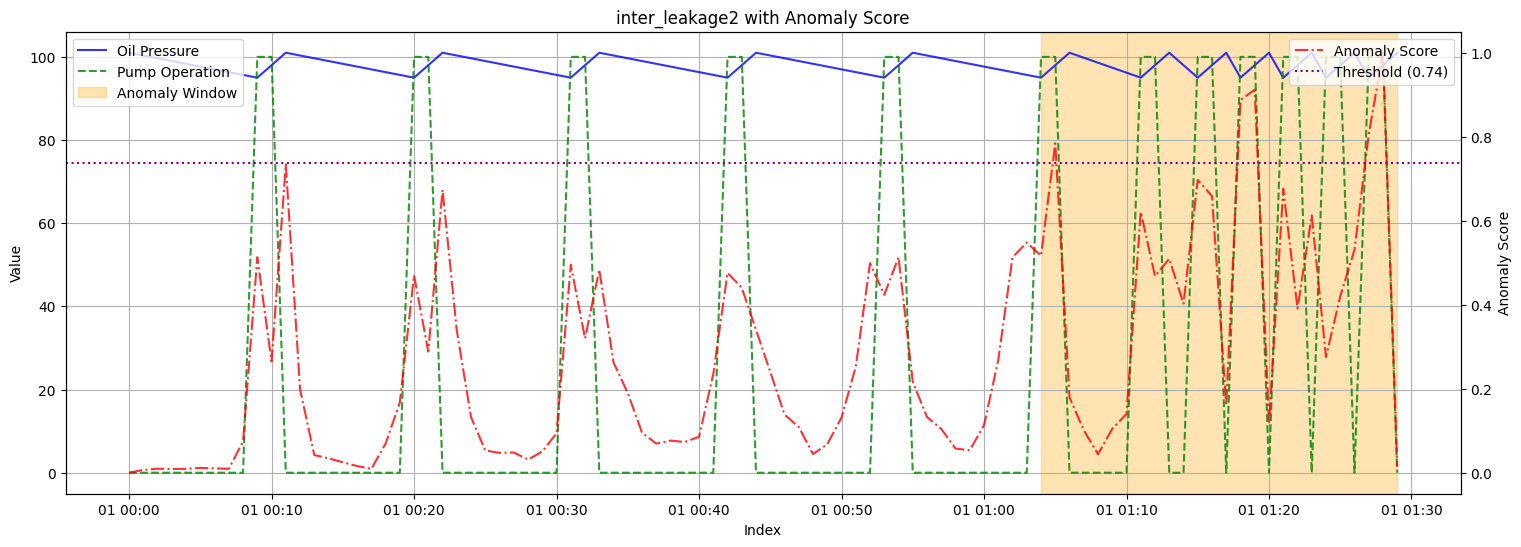

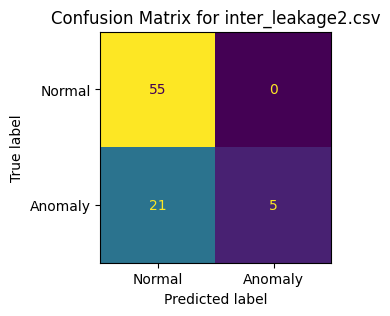

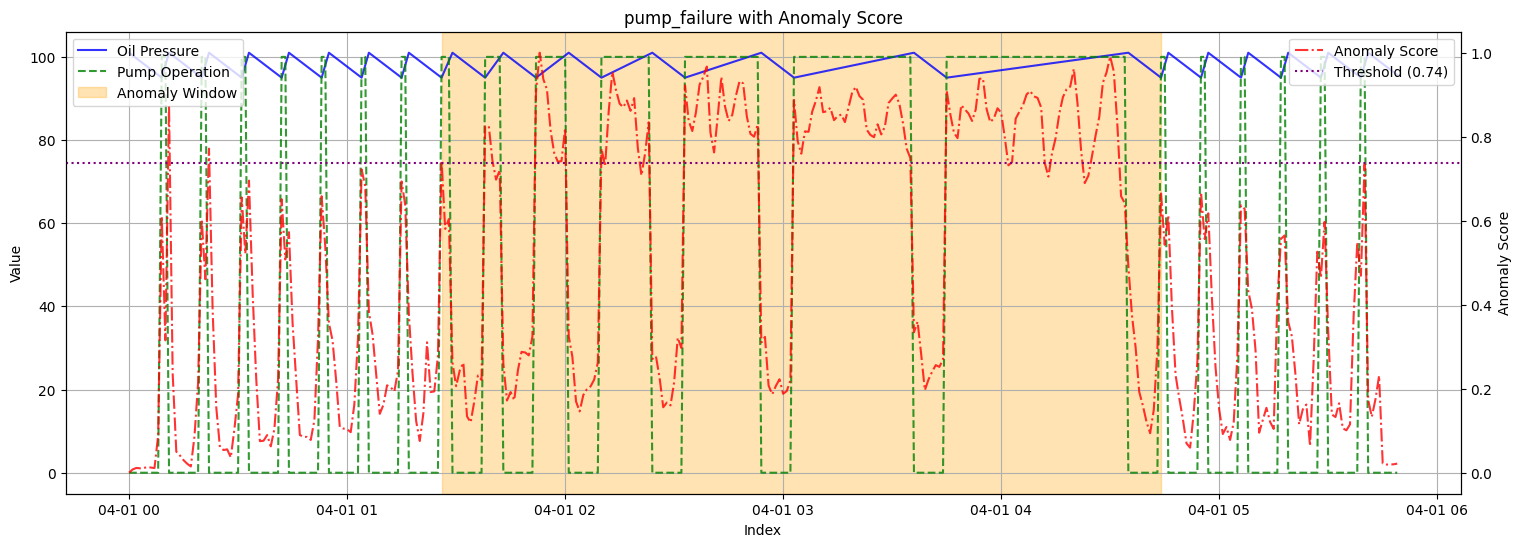

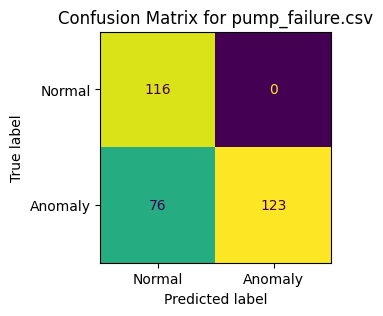

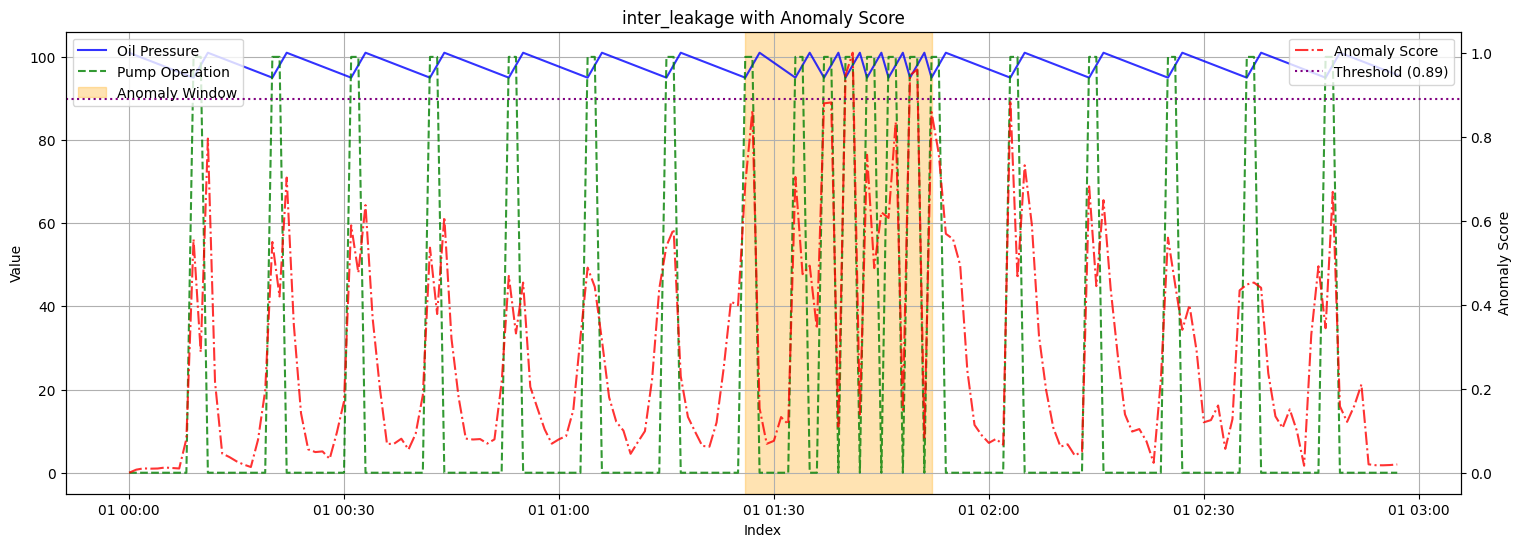

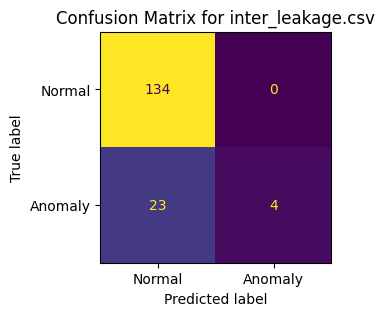

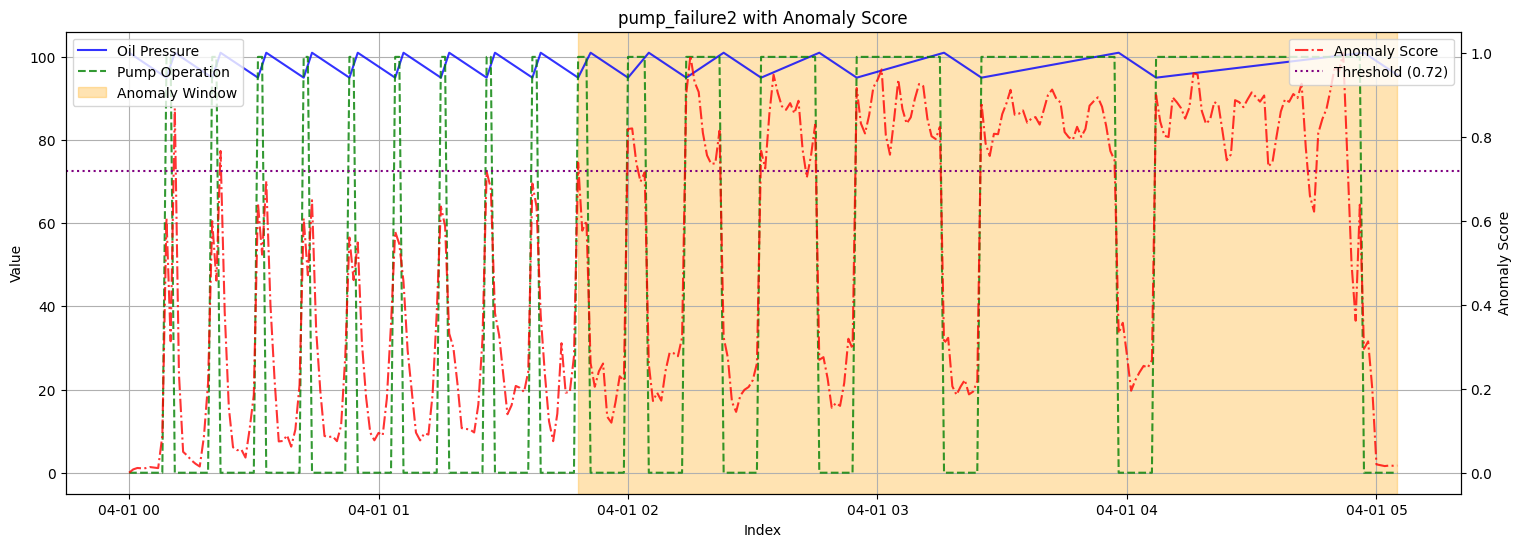

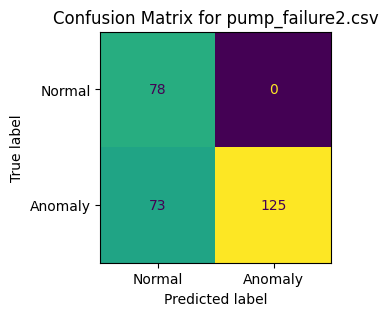

In [18]:
import NAB_scorer
importlib.reload(NAB_scorer)
from NAB_scorer import NABScorer

model_name = 'lstm_TL_u1'
results_dir = f'./results/{model_name}'
data_dict = load_score_files(results_dir)

scorer = NABScorer()
score = scorer.score(data_dict, label_dict, label_windowed=True, profile='reward_low_FP_rate')
for file_name, file_score in score.items():
    print(f"{file_name}: {file_score['score']}")
    
plot_all(score)
scores_total.append(score)

## Score lstm_TL_u2

windows: [(Timestamp('2024-04-01 01:48:00'), Timestamp('2024-04-01 05:05:00'))]
Normalized Score: 90.27, 
            score=0.756830594195369, 
            threshold=0.3181818181818182, 
            TP=126, TN=78, FP=0, FN=72

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 01:52:00'))]
Normalized Score: 95.41, 
            score=0.8851426312614474, 
            threshold=0.8363636363636363, 
            TP=5, TN=134, FP=0, FN=22

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 04:44:00'))]
Normalized Score: 87.41, 
            score=0.6852657009019265, 
            threshold=0.8181818181818181, 
            TP=25, TN=116, FP=0, FN=174

windows: [(Timestamp('2024-04-01 01:04:00'), Timestamp('2024-04-01 01:29:00'))]
Normalized Score: 93.63, 
            score=0.8407850447119221, 
            threshold=0.6363636363636364, 
            TP=8, TN=55, FP=0, FN=18

pump_failure2.csv: 90.27322376781477
inter_leakage.csv: 95.40570525045791
pump_failure.csv:

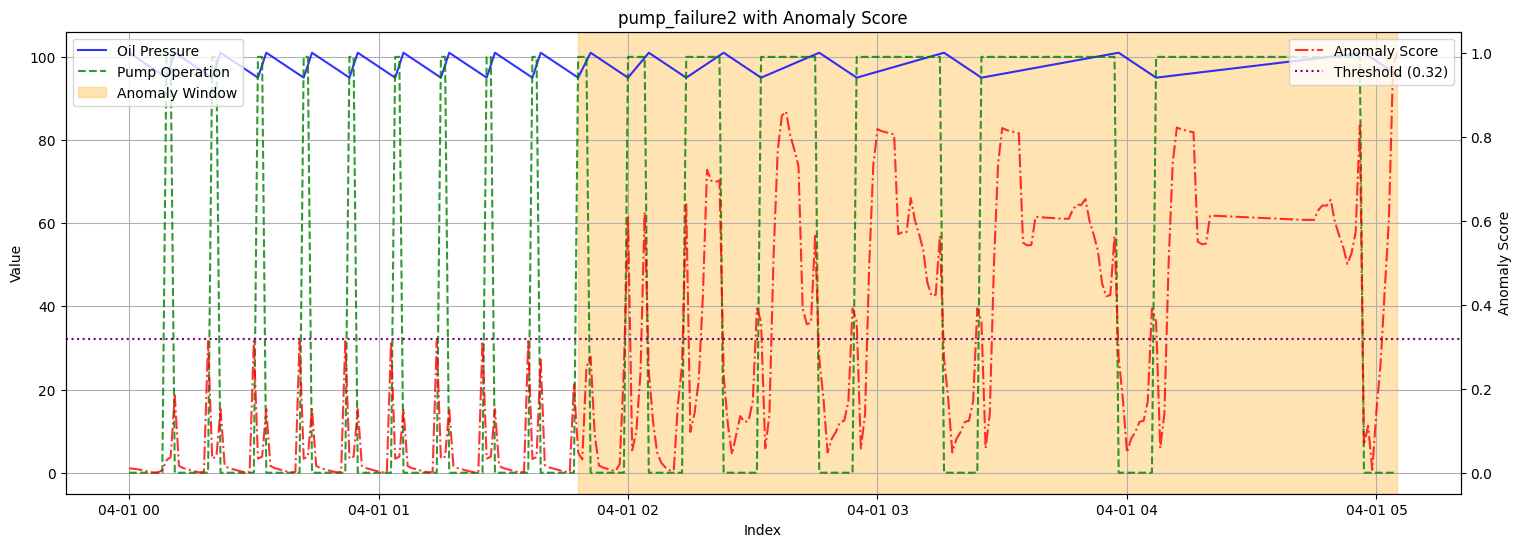

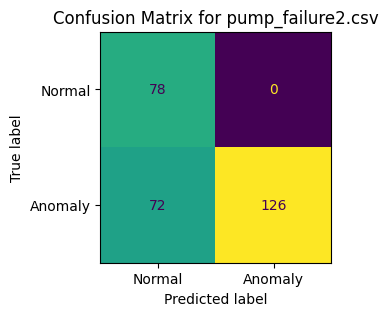

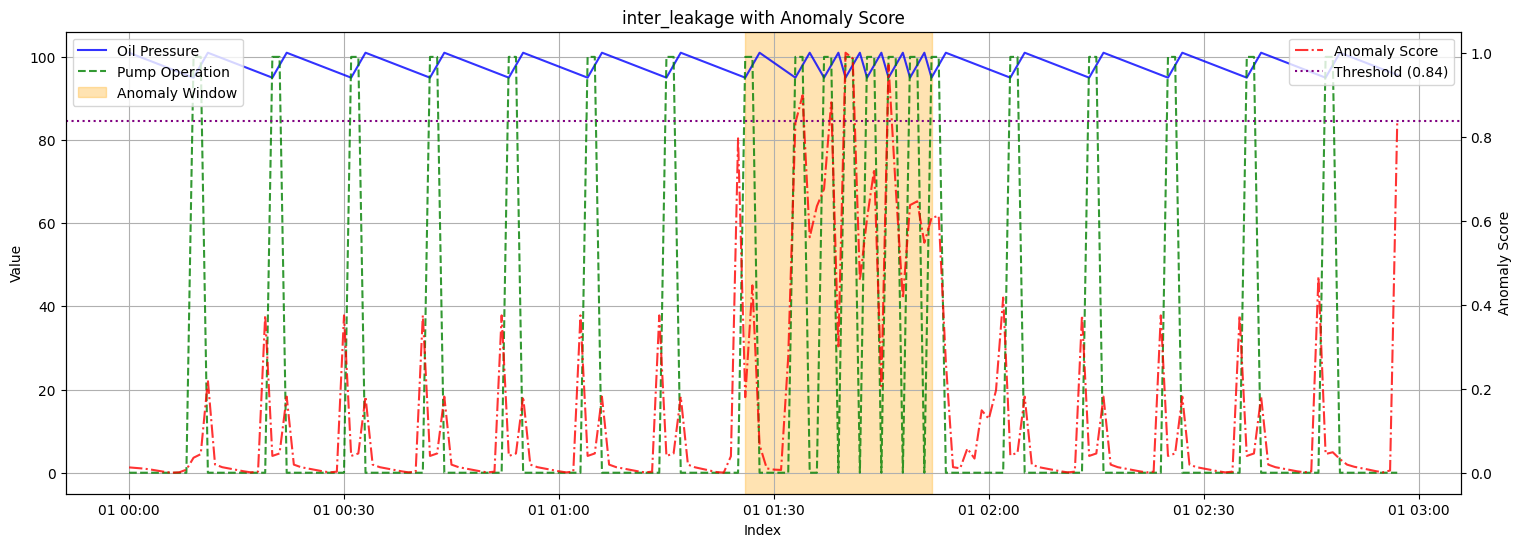

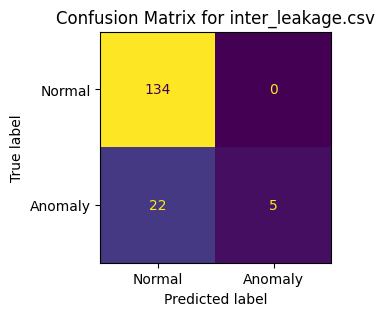

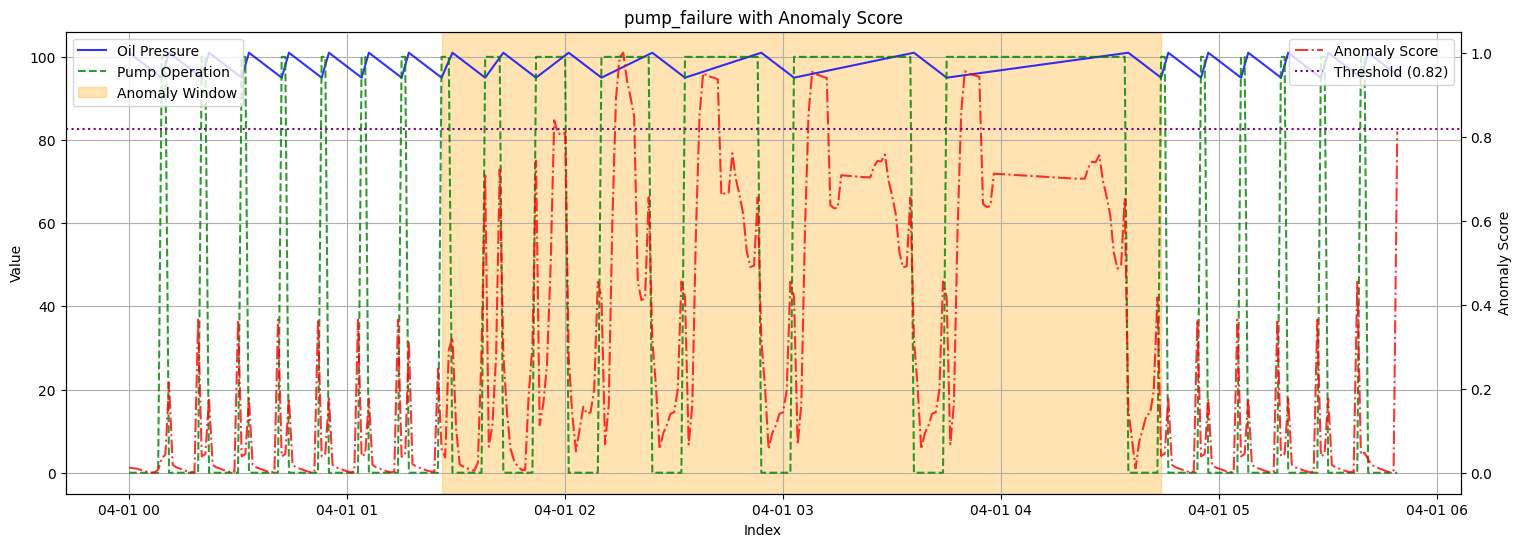

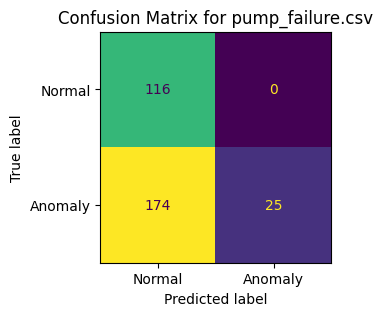

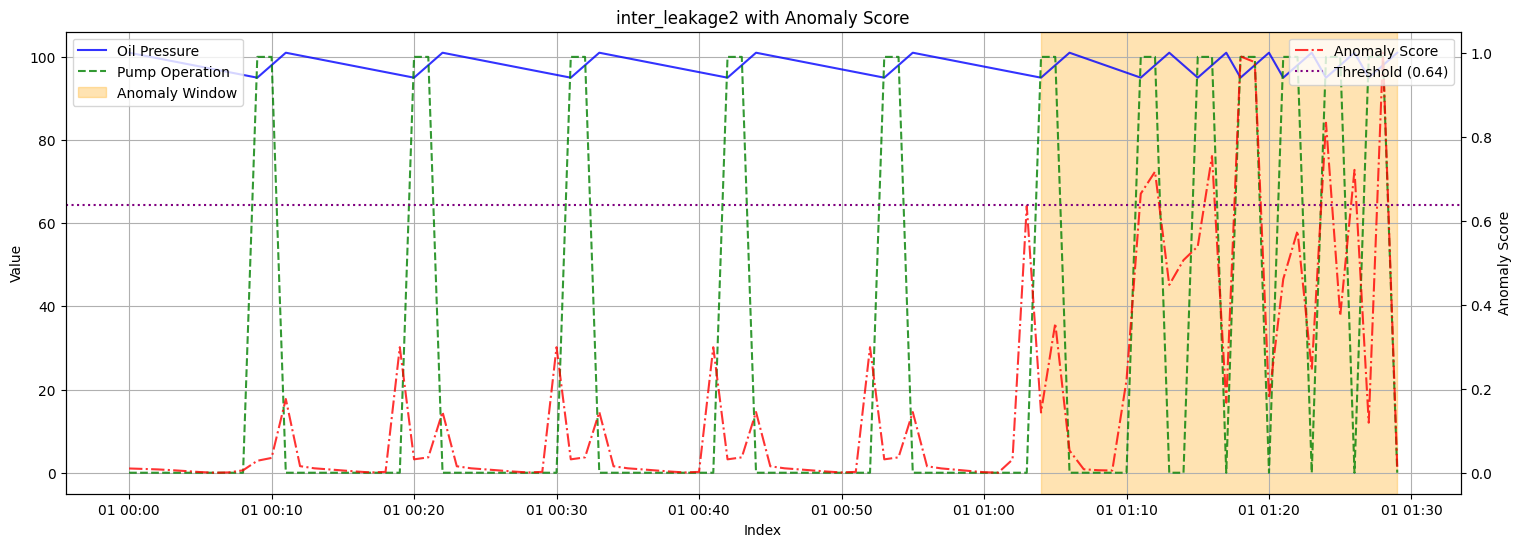

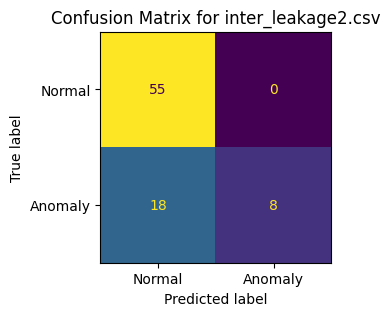

In [19]:
model_name = 'lstm_TL_u2'
results_dir = f'./results/{model_name}'
data_dict = load_score_files(results_dir)

scorer = NABScorer()
score = scorer.score(data_dict, label_dict, label_windowed=True, profile='reward_low_FP_rate')
for file_name, file_score in score.items():
    print(f"{file_name}: {file_score['score']}")
    
plot_all(score)
scores_total.append(score)

## Score lstm_small

windows: [(Timestamp('2024-04-01 01:04:00'), Timestamp('2024-04-01 01:29:00'))]
Normalized Score: 92.67, 
            score=0.8168370460803791, 
            threshold=0.8363636363636363, 
            TP=3, TN=55, FP=0, FN=23

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 01:52:00')), (Timestamp('2024-04-01 03:09:00'), Timestamp('2024-04-01 03:35:00')), (Timestamp('2024-04-01 04:52:00'), Timestamp('2024-04-01 05:18:00'))]
Normalized Score: 94.08, 
            score=0.8521182881663384, 
            threshold=0.8636363636363635, 
            TP=3, TN=265, FP=0, FN=78

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 01:52:00'))]
Normalized Score: 95.36, 
            score=0.8840897095572119, 
            threshold=0.8636363636363635, 
            TP=1, TN=134, FP=0, FN=26

windows: [(Timestamp('2024-04-01 01:48:00'), Timestamp('2024-04-01 05:05:00'))]
Normalized Score: 88.81, 
            score=0.7203243034872335, 
            threshold=0.51818181818

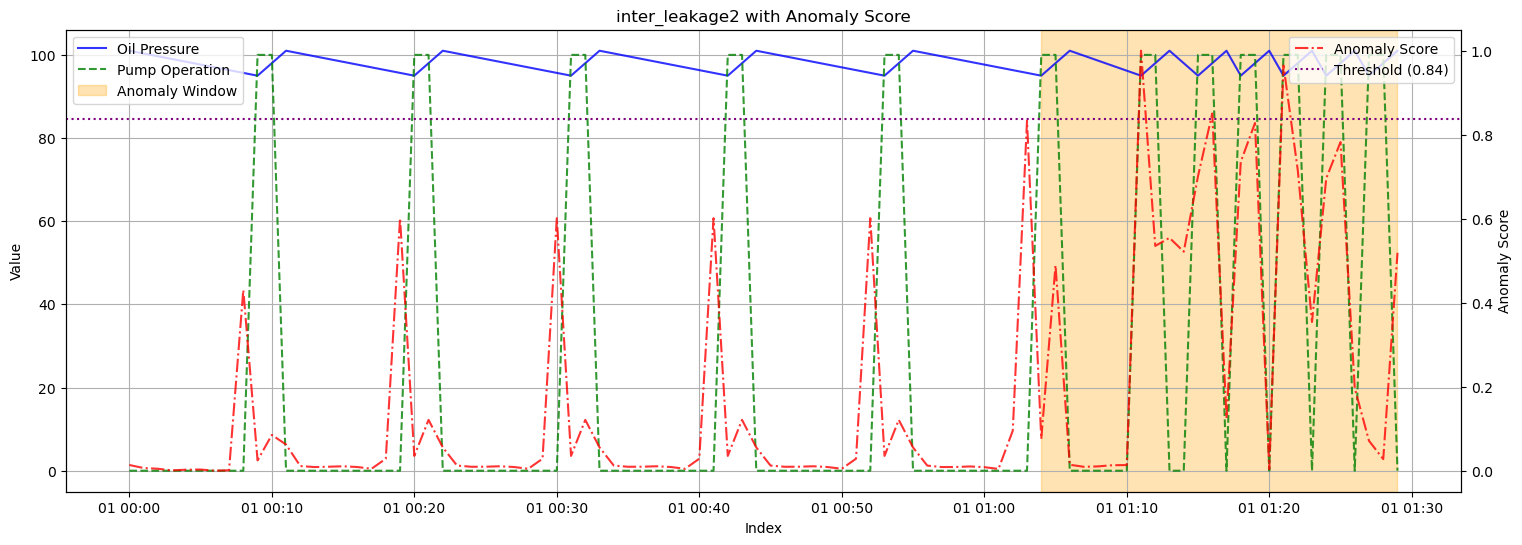

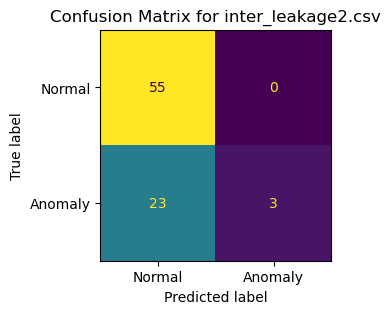

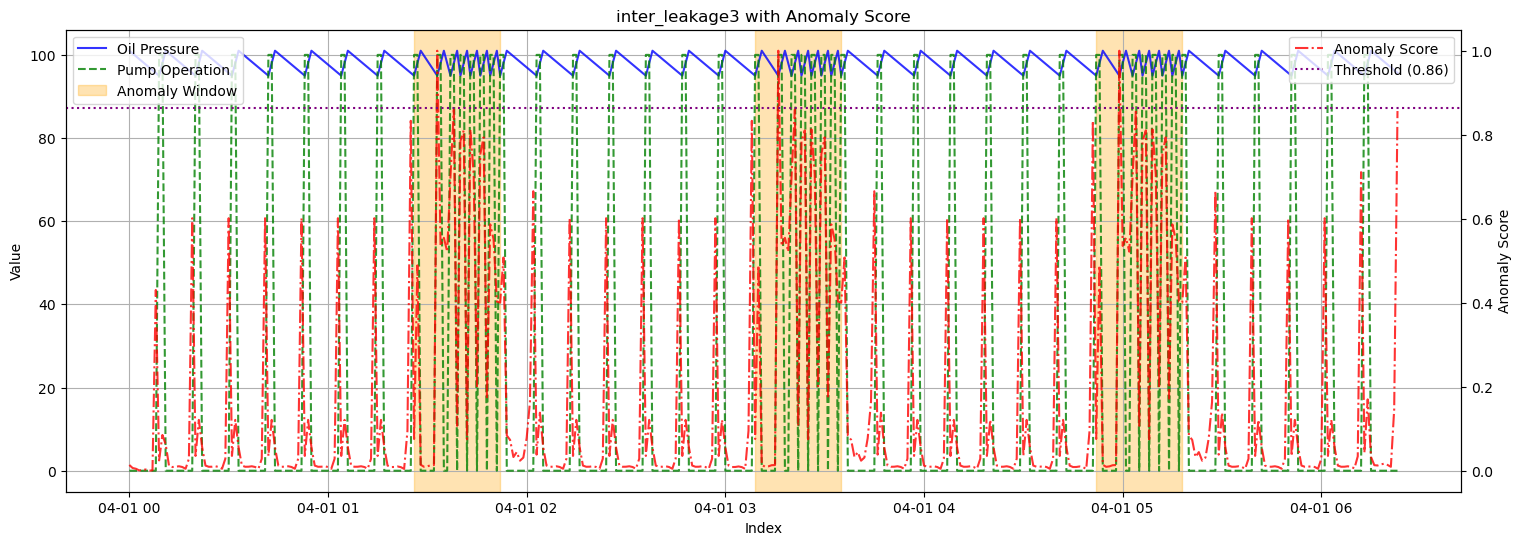

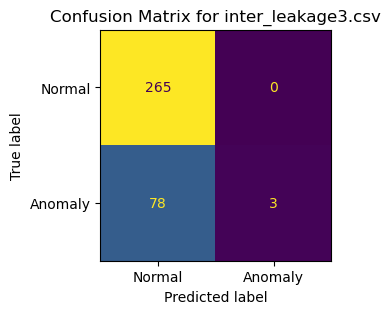

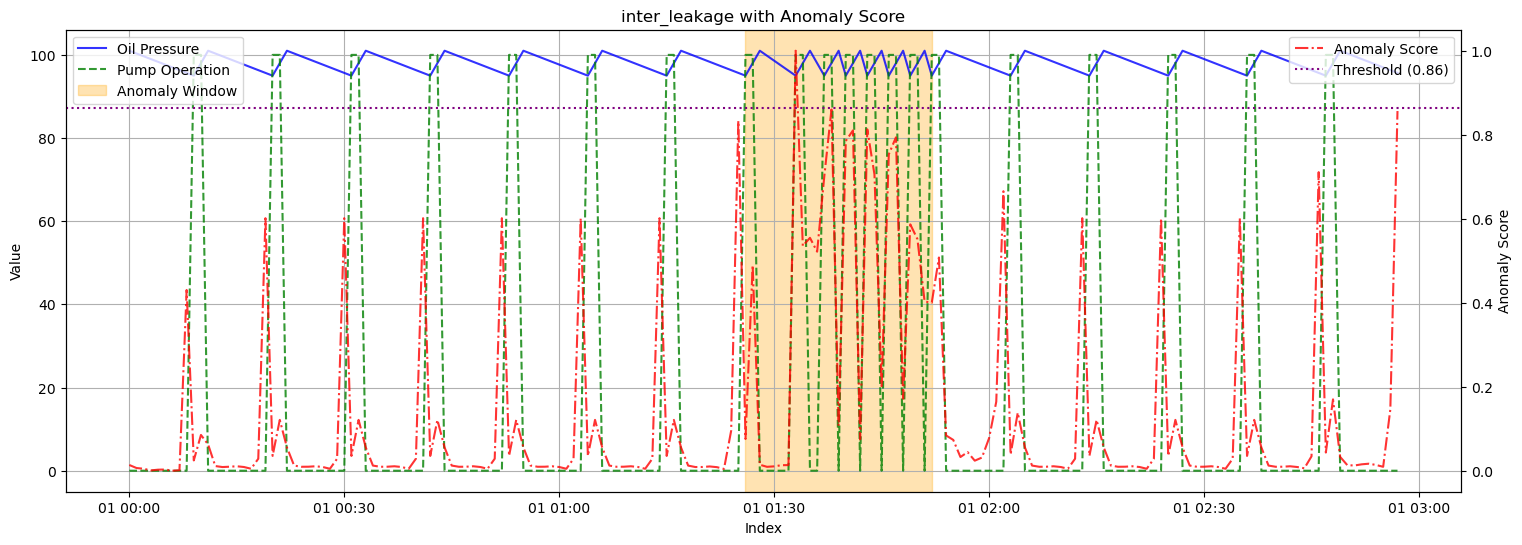

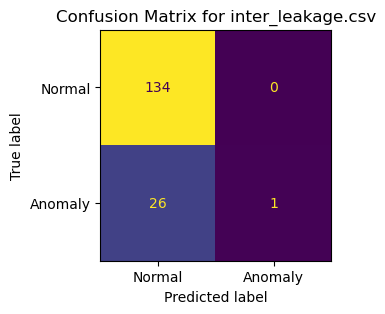

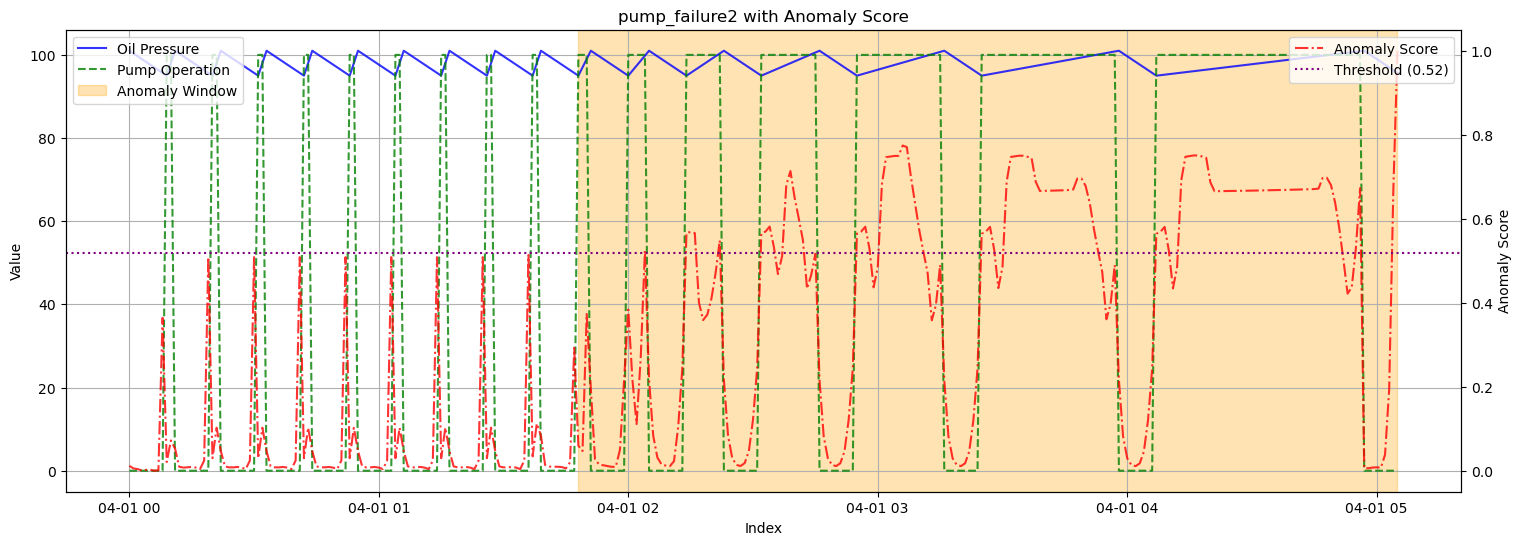

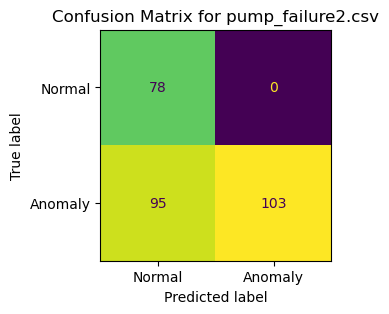

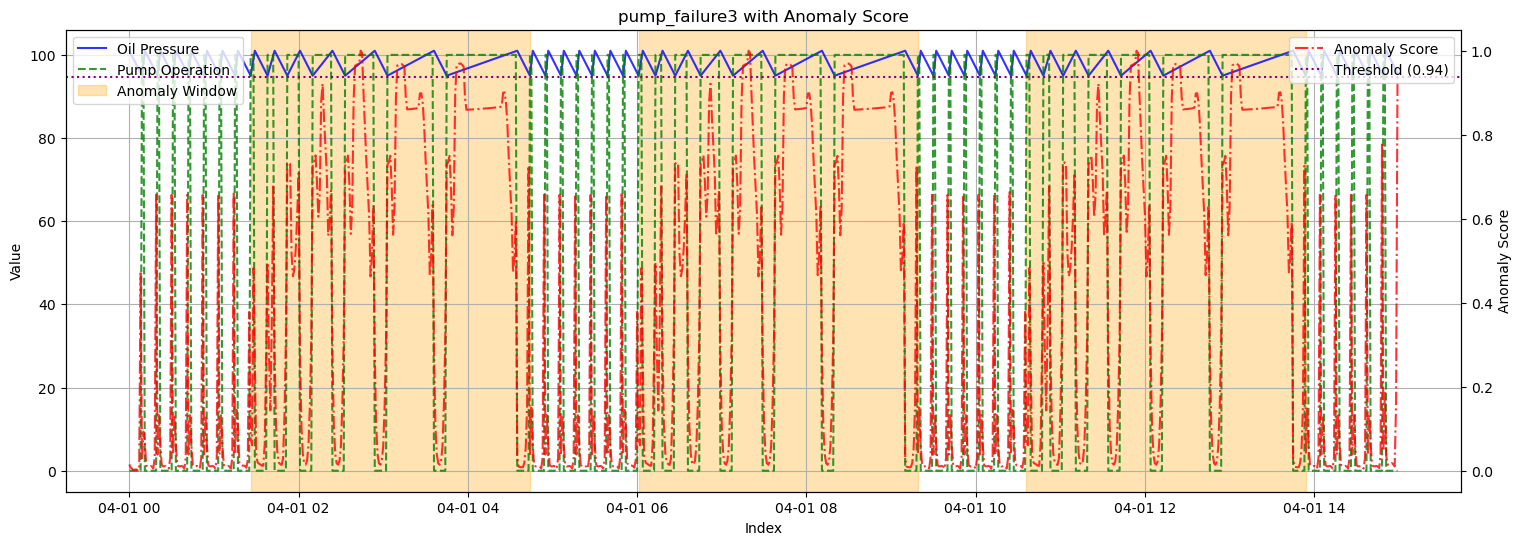

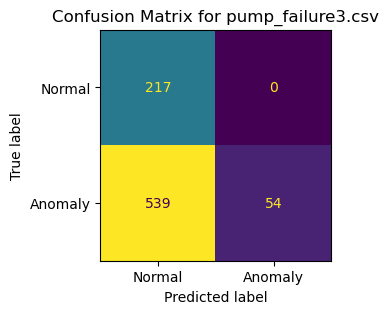

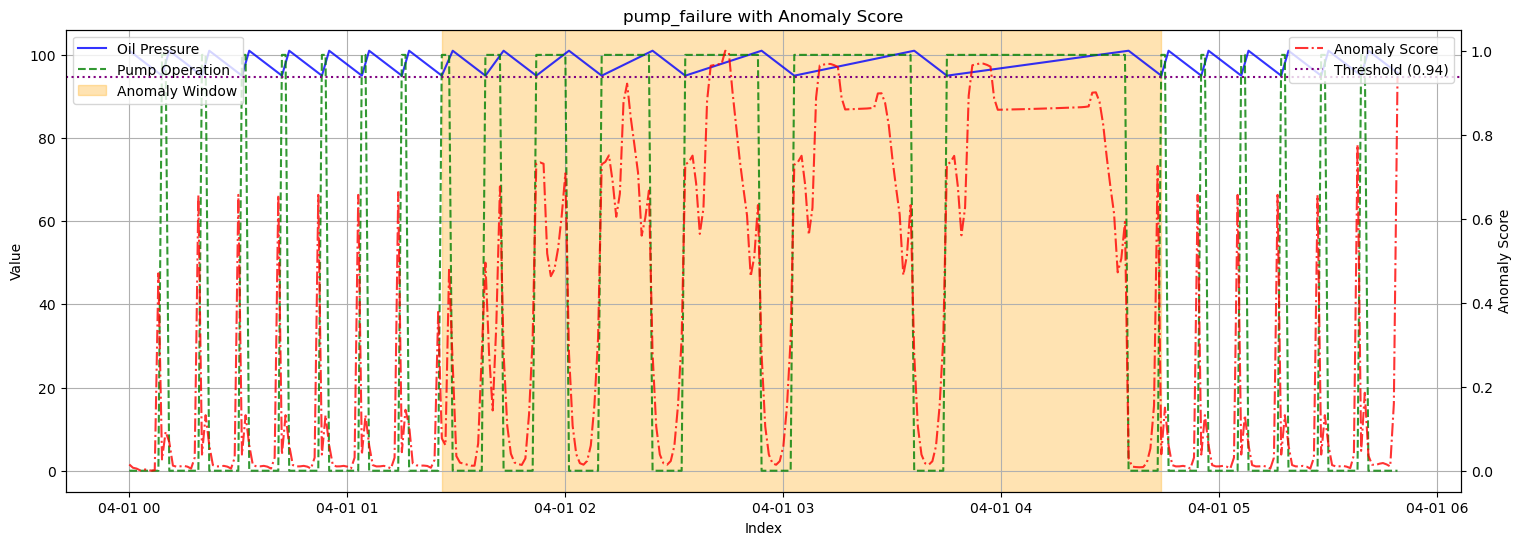

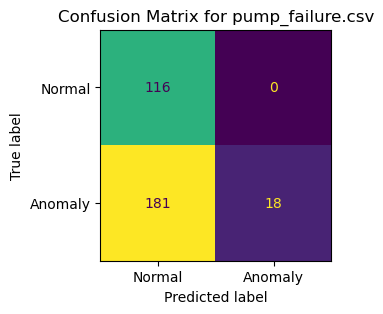

In [14]:
model_name = 'lstm_small'
results_dir = f'./results/{model_name}'
data_dict = load_score_files(results_dir)

scorer = NABScorer()
score = scorer.score(data_dict, label_dict, label_windowed=True, profile='reward_low_FP_rate')
for file_name, file_score in score.items():
    print(f"{file_name}: {file_score['score']}")
    
plot_all(score)
scores_total.append(score)

## Score lstm_TL_p2

windows: [(Timestamp('2024-04-01 01:04:00'), Timestamp('2024-04-01 01:29:00'))]
Normalized Score: 96.97, 
            score=0.9242424242424242, 
            threshold=0.3727272727272727, 
            TP=16, TN=55, FP=0, FN=10

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 01:52:00')), (Timestamp('2024-04-01 03:09:00'), Timestamp('2024-04-01 03:35:00')), (Timestamp('2024-04-01 04:52:00'), Timestamp('2024-04-01 05:18:00'))]
Normalized Score: 94.79, 
            score=0.8696688880301248, 
            threshold=0.7818181818181817, 
            TP=18, TN=265, FP=0, FN=63

windows: [(Timestamp('2024-04-01 01:26:00'), Timestamp('2024-04-01 01:52:00'))]
Normalized Score: 95.90, 
            score=0.8975273588644265, 
            threshold=0.7818181818181817, 
            TP=6, TN=134, FP=0, FN=21

windows: [(Timestamp('2024-04-01 01:48:00'), Timestamp('2024-04-01 05:05:00'))]
Normalized Score: 88.69, 
            score=0.7172200452202961, 
            threshold=0.663636363

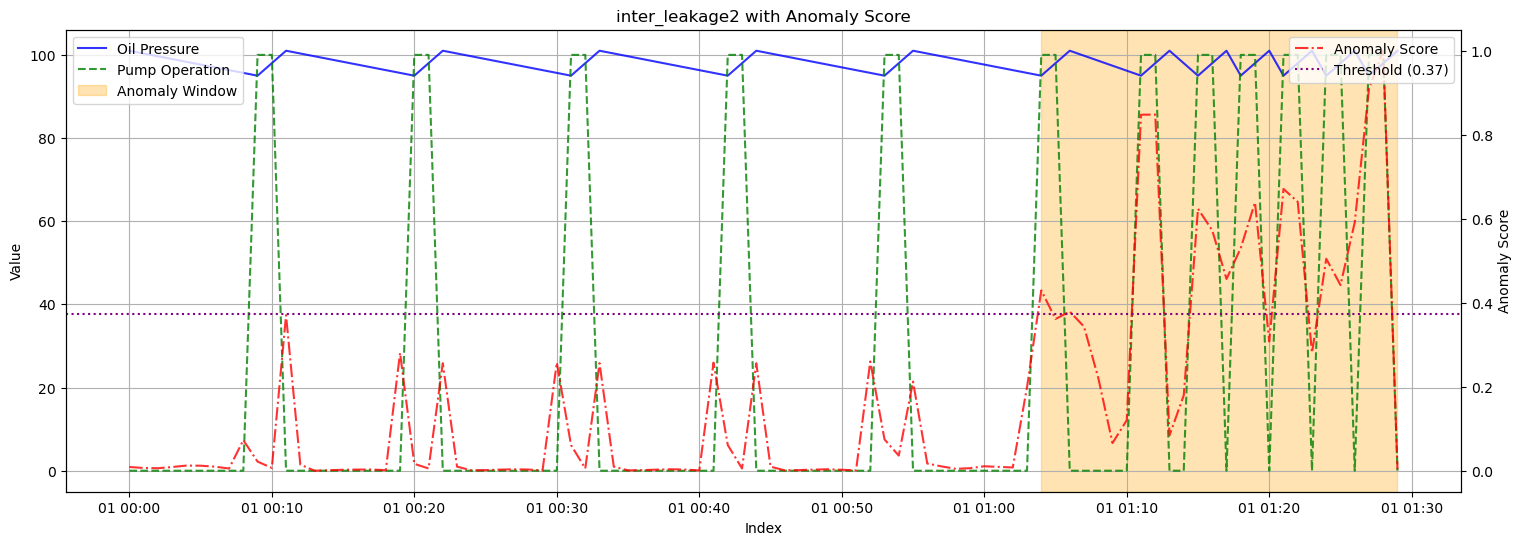

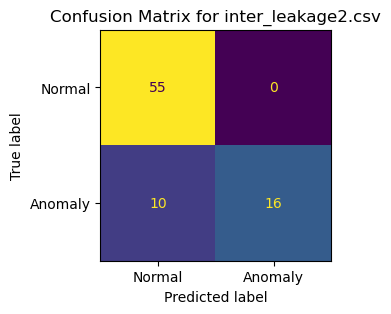

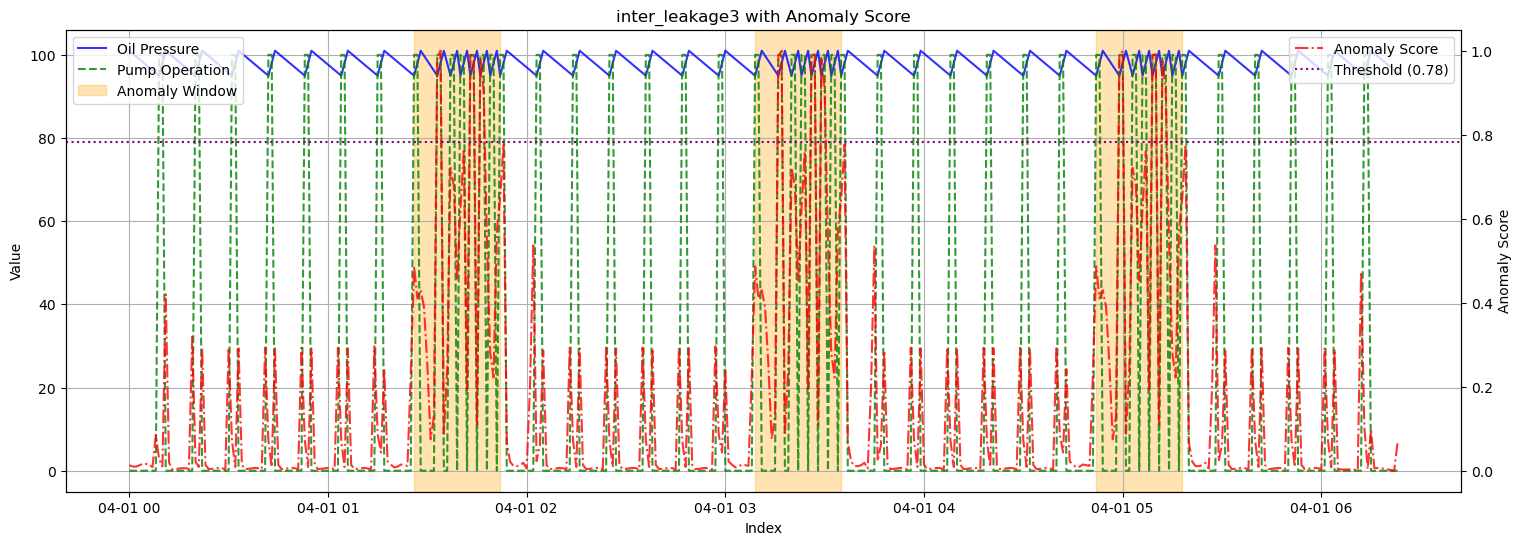

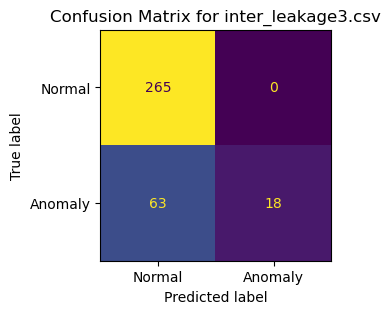

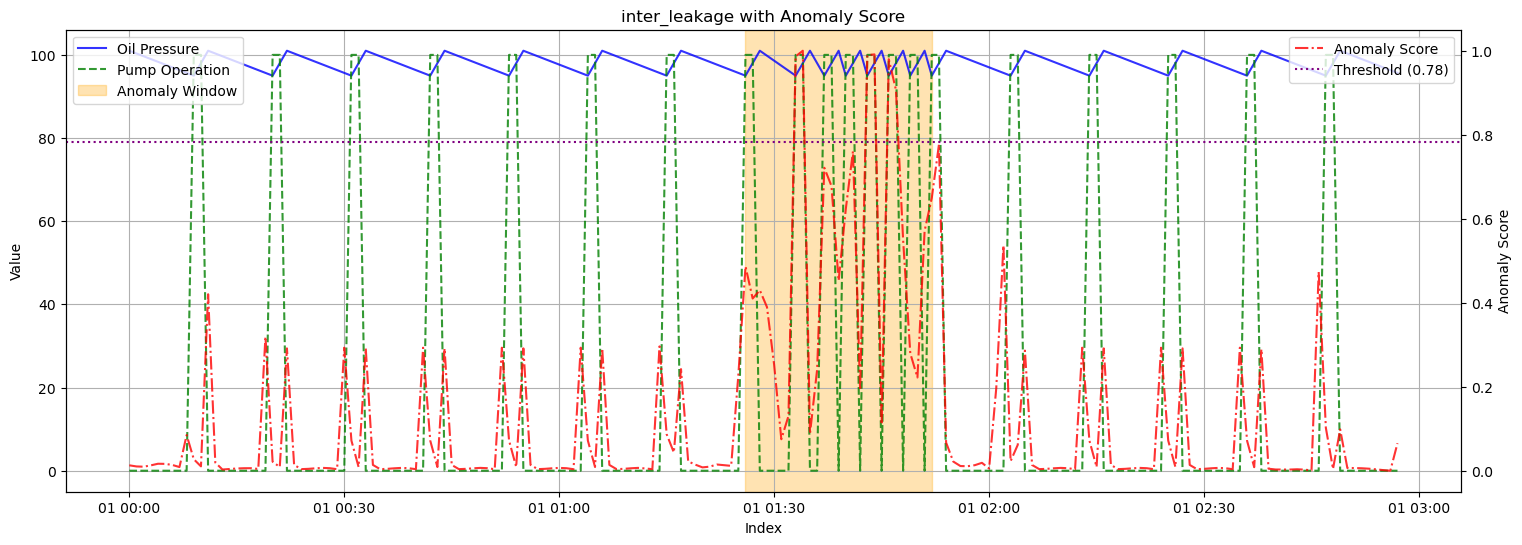

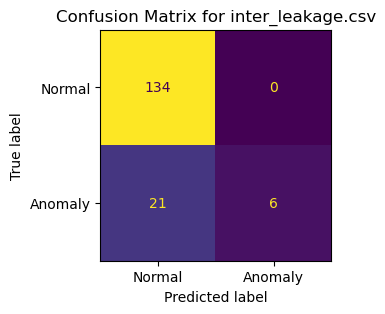

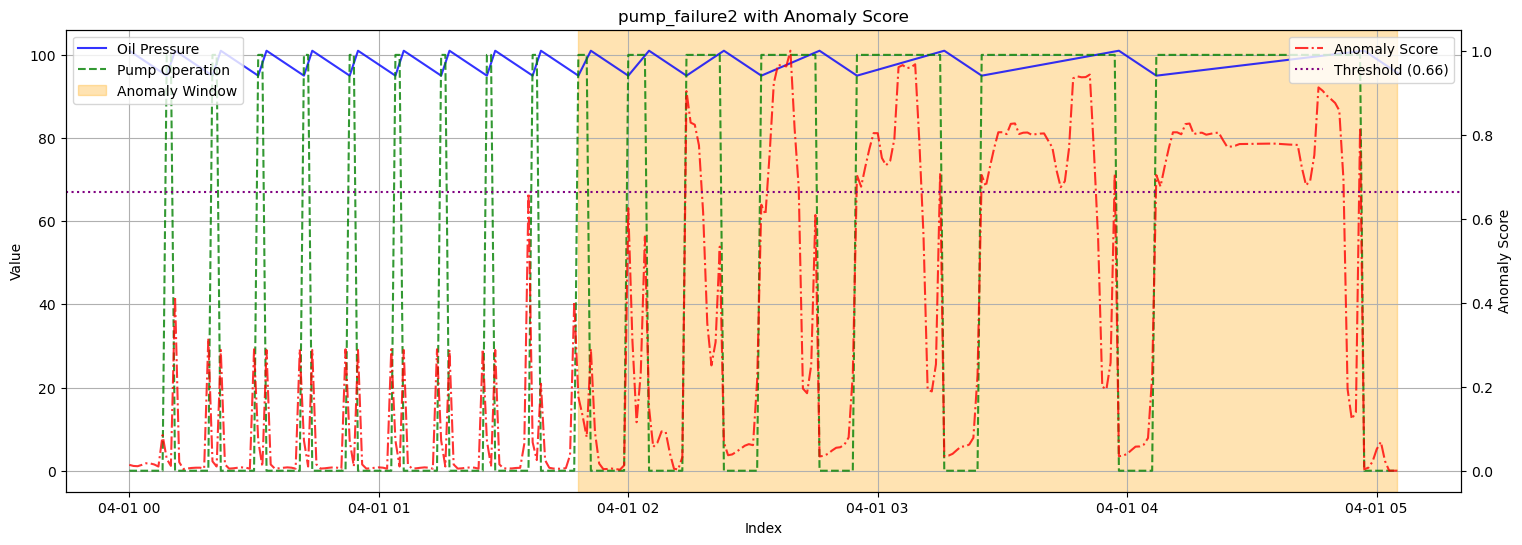

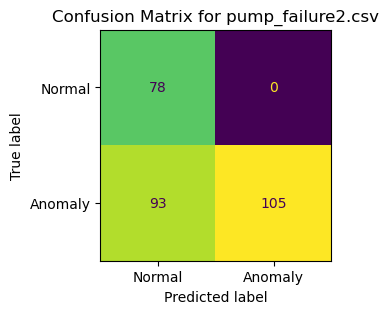

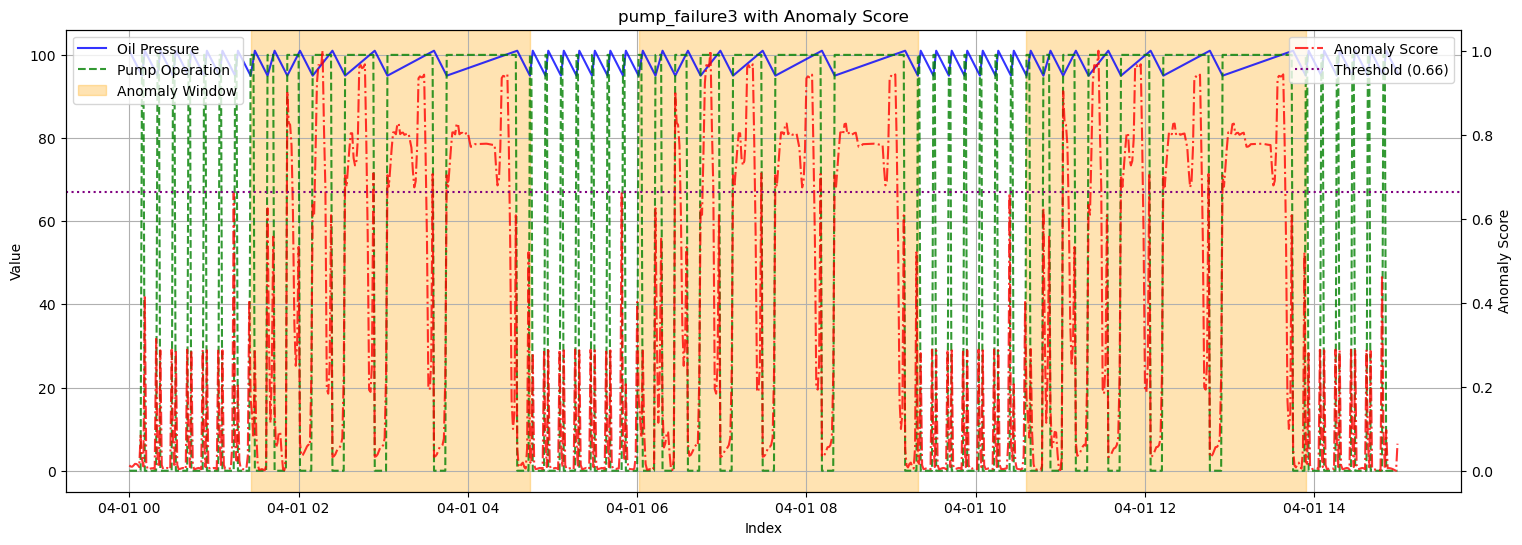

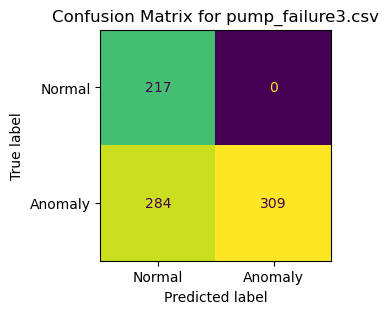

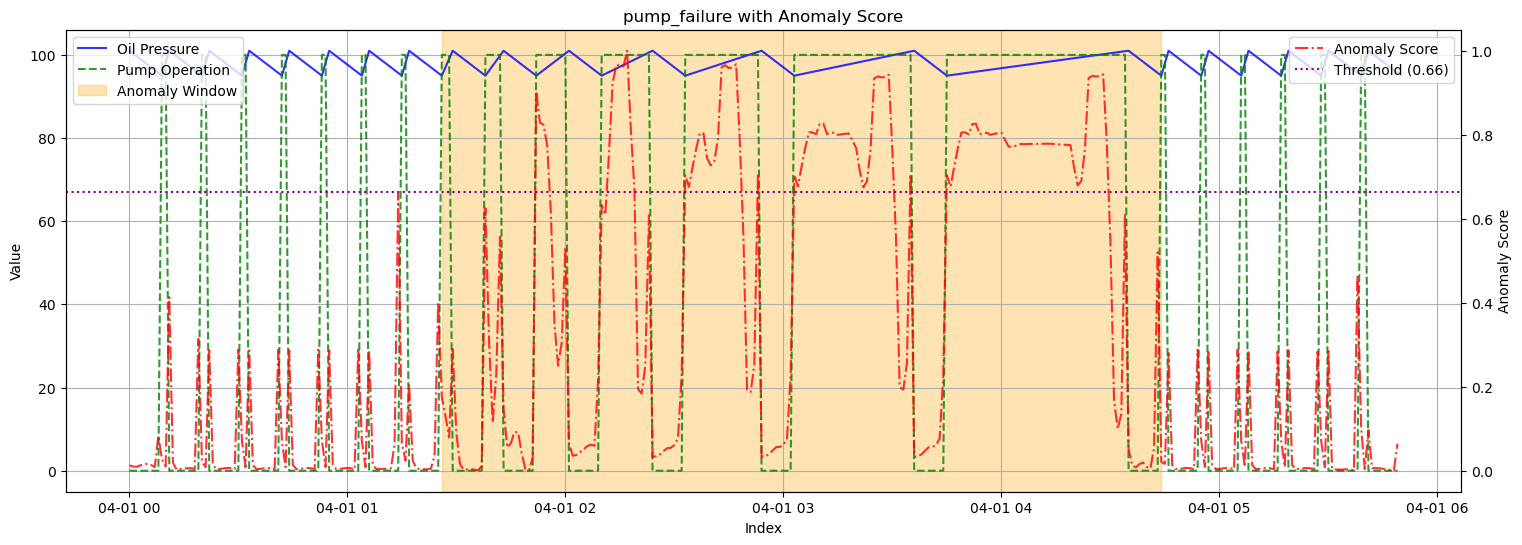

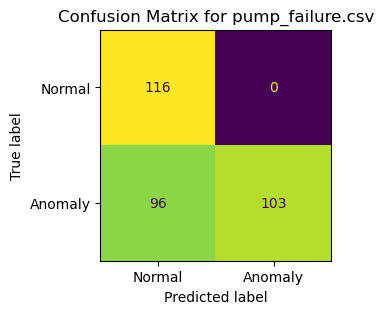

In [13]:
model_name = 'lstm_TL_p2'
results_dir = f'./results/{model_name}'
data_dict = load_score_files(results_dir)

scorer = NABScorer()
score = scorer.score(data_dict, label_dict, label_windowed=True, profile='reward_low_FP_rate')
for file_name, file_score in score.items():
    print(f"{file_name}: {file_score['score']}")
    
plot_all(score)
scores_total.append(score)

In [58]:
df_score = pd.DataFrame()
df_score.index = ['TL_u1', 'TL_u2', 'NoTL_small', 'TL_p2']
df_score['pump_failure'] = [score_u1['pump_failure.csv']['score'], score_u2['pump_failure.csv']['score'], score_small['pump_failure.csv']['score'], score_p2['pump_failure.csv']['score']]
df_score['inter_leakage'] = [score_u1['inter_leakage.csv']['score'], score_u2['inter_leakage.csv']['score'], score_small['inter_leakage.csv']['score'], score_p2['inter_leakage.csv']['score']]
df_score

pump_failure  inter_leakage
TL_u1          85.926909      95.084145
TL_u2          89.512400      97.535673
NoTL_small     84.451362      94.676053
TL_p2          88.012182      94.754193

In [ ]:
label_dict = json.load(open('../shf_labels.json'))

data_dict = {
    "pump_failure.csv": data1,
    "inter_leakage.csv": data2,
}

# Initialize scorer
scorer = NABScorer()

profiles = ["reward_low_FN_rate", "reward_low_FP_rate", "reward_low_FN_rate"]
scores = []

# Calculate scores
for p in profiles:
    scores.append(scorer.score(data_dict, label_dict, profile=p))
print('Final scores', scores)